In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [103]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='full_window', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
                    #   mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')

da.load_results_da()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


In [105]:
def find_k_nearest_neighbors(phi_psi_dist, preds, k=10):
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]
    phi_psi_dist = phi_psi_dist.values
    pred = np.concatenate([preds['phi'].values, preds['psi'].values])

    # Calculate the distances
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    distances = np.sqrt(np.sum((diff(pred, phi_psi_dist))**2, axis=1))

    nearest = np.argsort(distances)[:k]
    return phi_psi_dist[nearest], distances[nearest]

# nearest, distances = find_k_nearest_neighbors(phi_psi_dist, xrays, k=10)

In [39]:
def find_k_nearest_neighbors2(phi_psi_dist, preds, k=10):
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]

    preds = preds[['protein_id', 'pos', 'phi', 'psi']].pivot(index='protein_id', columns='pos', values=['phi', 'psi'])
    preds.columns = [f'{c[0]}_{c[1]}' for c in preds.columns.to_flat_index()]

    phi_psi_dist = phi_psi_dist.values
    preds = preds.values

    # Calculate the distance matrix
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    
    distances = np.linalg.norm(diff(preds[:,np.newaxis], phi_psi_dist), axis=2)
    nearest = np.argsort(distances, axis=1)[:, :k]
    return distances[np.arange(distances.shape[0])[:, np.newaxis], nearest]

In [137]:
def find_neighbors_in_threshold(phi_psi_dist, preds, threshold=30):
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]
    phi_psi_dist = phi_psi_dist.values
    pred = np.concatenate([preds['phi'].values, preds['psi'].values])

    # Calculate the distances
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    distances = np.sqrt(np.sum((diff(pred, phi_psi_dist))**2, axis=1))
    return (distances < threshold).sum()

# nearest, distances = find_k_nearest_neighbors(phi_psi_dist, xrays, k=10)
def find_neighbors_in_threshold2(phi_psi_dist, preds, threshold=30):
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]

    preds = preds[['protein_id', 'pos', 'phi', 'psi']].pivot(index='protein_id', columns='pos', values=['phi', 'psi'])
    preds.columns = [f'{c[0]}_{c[1]}' for c in preds.columns.to_flat_index()]

    phi_psi_dist = phi_psi_dist.values
    preds = preds.values

    # Calculate the distance matrix
    def diff(x1, x2):
        d = np.abs(x1 - x2)
        return np.minimum(d, 360-d)
    
    distances = np.linalg.norm(diff(preds[:,np.newaxis], phi_psi_dist), axis=2)
    return (distances < threshold).sum(axis=1)

In [140]:
def calc_score(ins, thresholds):
    # ins is dihedral adherence object
    # q is the query object for a window size
    ins.phi_psi_predictions['new_score'] = np.nan
    ins.xray_phi_psi['new_score'] = np.nan

    center_idx_ctxt = ins.queries[-1].get_center_idx()
    winsize_ctxt = ins.queries[-1].winsize
    if center_idx_ctxt < 0:
        center_idx_ctxt = winsize_ctxt + center_idx_ctxt
    for i,seq_ctxt in enumerate(ins.xray_phi_psi.seq_ctxt[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]):
        print(f'{i}/{ins.xray_phi_psi.shape[0] - winsize_ctxt}', seq_ctxt)

        pred_scores_qs = []
        xray_score_qs = []
        n_queries = 1
        for q,t in zip(ins.queries[:n_queries], thresholds[:n_queries]):
            seq = q.get_subseq(seq_ctxt)
            phi_psi_dist = q.results_window[q.results_window['seq'] == seq]
            if phi_psi_dist.shape[0] < t:
                print('\tSkipping', seq, 'Not enough data')
                continue

            center_idx = q.get_center_idx()
            if center_idx < 0:
                center_idx = q.winsize + center_idx
            
            xray_pos = ins.xray_phi_psi[ins.xray_phi_psi.seq_ctxt == seq_ctxt].pos.iloc[0]
            xrays = ins.xray_phi_psi[(ins.xray_phi_psi.pos >= xray_pos-center_idx) & (ins.xray_phi_psi.pos < xray_pos-center_idx+q.winsize)]

            pred_pos = ins.phi_psi_predictions[ins.phi_psi_predictions.seq_ctxt == seq_ctxt].pos.unique()
            if len(pred_pos) == 0:
                print('\tSkipping', seq_ctxt, 'Prediction Positions are not unique')
                continue
            pred_pos = pred_pos[0]
            preds = ins.phi_psi_predictions[(ins.phi_psi_predictions.pos >= pred_pos-center_idx) & (ins.phi_psi_predictions.pos < pred_pos-center_idx+q.winsize)]

            if xrays.shape[0] < q.winsize or preds.shape[0] % q.winsize != 0:
                print('\tSkipping', seq_ctxt, 'Not enough xray or prediction data')
                continue
            pred_scores = find_neighbors_in_threshold2(phi_psi_dist, preds, t)
            pred_scores_qs.append(pred_scores)

            xray_score = find_neighbors_in_threshold(phi_psi_dist, xrays, t)
            xray_score_qs.append(xray_score)

            print('\t', seq, q.winsize, phi_psi_dist.shape[0] // q.winsize, np.nanmean(pred_scores).round(2), xray_score.round(2))

        # For now, only use first two queries
        if len(pred_scores_qs) < n_queries:
            print('Skipping', seq_ctxt, 'Missing data for window sizes')
            continue
        pred_scores = np.stack(pred_scores_qs)
        xrays = np.array(xray_score_qs)

        pred_scores = np.mean(pred_scores, axis=0)
        xray_score = np.mean(xrays)

        ins.phi_psi_predictions.loc[ins.phi_psi_predictions.seq_ctxt == seq_ctxt, 'new_score'] = pred_scores
        ins.xray_phi_psi.loc[ins.xray_phi_psi.seq_ctxt == seq_ctxt, 'new_score'] = xray_score
thresholds = [15, 5, 2, 2]
calc_score(da, thresholds)

0/366 WNLDKNL
	 LDKN 4 2427 1.14 0
1/366 NLDKNLQ
	 DKNL 4 3165 4.5 0
2/366 LDKNLQL
	 KNLQ 4 2662 85.45 20
3/366 DKNLQLR
	 NLQL 4 1602 25.75 74
4/366 KNLQLRL
	 LQLR 4 2892 121.43 226
5/366 NLQLRLG
	 QLRL 4 2633 123.76 253
6/366 LQLRLGI
	 LRLG 4 4454 107.14 95
7/366 QLRLGIV
	 RLGI 4 4135 110.81 56
8/366 LRLGIVF
	 LGIV 4 3126 200.38 69
9/366 RLGIVFL
	 GIVF 4 1756 41.15 1
10/366 LGIVFLG
	 IVFL 4 2195 187.64 16
11/366 GIVFLGA
	 VFLG 4 4127 99.91 2
12/366 IVFLGAF
	 FLGA 4 3914 136.86 9
13/366 VFLGAFS
	 LGAF 4 3888 144.77 8
14/366 FLGAFSY
	 GAFS 4 3149 90.14 1
15/366 LGAFSYG
	 AFSY 4 1390 16.6 2
16/366 GAFSYGT
	 FSYG 4 1625 4.58 0
17/366 AFSYGTV
	 SYGT 4 1329 2.31 0
18/366 FSYGTVF
	 YGTV 4 926 1.31 0
19/366 SYGTVFS
	 GTVF 4 1901 18.87 0
20/366 YGTVFSS
	 TVFS 4 2915 24.76 0
21/366 GTVFSSM
	 VFSS 4 2491 16.76 0
22/366 TVFSSMT
	 FSSM 4 543 14.36 0
23/366 VFSSMTI
	 SSMT 4 2214 129.81 0
24/366 FSSMTIY
	 SMTI 4 795 15.65 0
25/366 SSMTIYY
	 MTIY 4 335 16.27 1
26/366 SMTIYYN
	 TIYY 4 1943 6.88 2
27/3

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch

def plot(ins, q, seq_ctxt, protein_id, k):
    # seq_ctxt = 'TFVMTET'
    print(seq_ctxt)
    seq = q.get_subseq(seq_ctxt)

    center_idx = q.get_center_idx()
    if center_idx < 0:
        center_idx = q.winsize + center_idx
    xray_pos = ins.xray_phi_psi[ins.xray_phi_psi.seq_ctxt == seq_ctxt].pos.iloc[0]
    xrays = ins.xray_phi_psi[(ins.xray_phi_psi.pos >= xray_pos-center_idx) & (ins.xray_phi_psi.pos < xray_pos-center_idx+q.winsize)]

    pred_mask = ins.phi_psi_predictions.protein_id == protein_id
    pred_pos = ins.phi_psi_predictions[(ins.phi_psi_predictions.seq_ctxt == seq_ctxt) & pred_mask].pos.iloc[0]
    preds = ins.phi_psi_predictions[pred_mask & ((ins.phi_psi_predictions.pos >= pred_pos-center_idx) & (ins.phi_psi_predictions.pos < pred_pos-center_idx+q.winsize))]
    fig, axes = plt.subplots(2, q.winsize, figsize=(15, 10), sharey='row')

    df = q.results_window[q.results_window['seq'] == seq]
    print(df.shape[0] // q.winsize)
    nearest, distances = find_k_nearest_neighbors(df, xrays, k=k)
    # average_nearest = np.stack(np.split(nearest.mean(axis=0), 2)).T
    nearest = np.stack([nearest[:, :q.winsize], nearest[:, q.winsize:]]).transpose(1,2,0)

    pred_nearest, pred_distances = find_k_nearest_neighbors(df, preds, k=k)
    pred_nearest = np.stack([pred_nearest[:, :q.winsize], pred_nearest[:, q.winsize:]]).transpose(1,2,0)

    for i, ax in enumerate(axes[0]):
        dist = df[df['window_pos'] == i]
        if q.winsize > 4:
            ax.scatter(dist.phi, dist.psi, marker='.', label='PDBMine')
        else:
            sns.kdeplot(data=dist, x='phi', y='psi', label='PDBMine', ax=ax, fill=True, bw_method=0.1)
        ax.scatter(xrays.iloc[i].phi, xrays.iloc[i].psi, marker='x', color='red', label='X-ray')
        # ax.scatter(afs.iloc[i].phi, afs.iloc[i].psi, marker='x', color='purple')
        ax.scatter(preds.iloc[i].phi, preds.iloc[i].psi, marker='x', color='blue', label=protein_id)
        ax.scatter(nearest[:, i, 0], nearest[:, i, 1], marker='^', color='purple', label='K-Nearest to X-Ray', alpha=0.5)
        ax.scatter(pred_nearest[:, i, 0], pred_nearest[:, i, 1], marker='^', color='orange', label='K-Nearest to Prediction', alpha=0.5)
        ax.set_xlim(-180, 180)
        ax.set_ylim(-180, 180)
        ax.title.set_text(dist.iloc[0].res)
        ax.set_xlabel('Phi')
        if i == 0:
            ax.set_ylabel('Psi')
        if i == len(axes[0])-1:
            ax.legend()

    xmax = max(xrays.phi.max(), preds.phi.max(), nearest[:, :, 0].max(), pred_nearest[:, :, 0].max()) + 20
    ymax = max(xrays.psi.max(), preds.psi.max(), nearest[:, :, 1].max(), pred_nearest[:, :, 1].max()) + 20
    xmin = min(xrays.phi.min(), preds.phi.min(), nearest[:, :, 0].min(), pred_nearest[:, :, 0].min()) - 20
    ymin = min(xrays.psi.min(), preds.psi.min(), nearest[:, :, 1].min(), pred_nearest[:, :, 1].min()) - 20
    for i, ax in enumerate(axes[1]):
        dist = df[df['window_pos'] == i]
        ax.scatter(dist.phi, dist.psi, marker='.', label='PDBMine')
        # sns.kdeplot(data=dist, x='phi', y='psi', label='PDBMine', ax=ax, fill=True, bw_method=0.1)
        ax.scatter(xrays.iloc[i].phi, xrays.iloc[i].psi, marker='x', color='red', label='X-ray', s=100, zorder=100)
        ax.scatter(preds.iloc[i].phi, preds.iloc[i].psi, marker='x', color='blue', label=protein_id, s=100, zorder=100)
        ax.scatter(nearest[:, i, 0], nearest[:, i, 1], marker='^', color='purple', label='K-Nearest to X-Ray', alpha=0.5, s=100)
        # ax.scatter(average_nearest[i, 0], average_nearest[i, 1], marker='o', color='orange', label='Average Nearest')
        ax.scatter(pred_nearest[:, i, 0], pred_nearest[:, i, 1], marker='^', color='orange', label='K-Nearest to Prediction', alpha=0.5, s=100)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.title.set_text(dist.iloc[0].res)
        ax.set_xlabel('Phi')
        if i == 0:
            ax.set_ylabel('Psi')
        if i == len(axes[0])-1:
            ax.legend()

    # draw lines
    for i in range(q.winsize-1):

        for j in range(nearest.shape[0]):
            con = ConnectionPatch(
                xyA=(nearest[j, i, 0], nearest[j, i, 1]), 
                xyB=(nearest[j, i+1, 0], nearest[j, i+1, 1]), 
                coordsA="data", coordsB="data", 
                axesA=axes[1,i], axesB=axes[1,i+1], 
                color='purple', lw=1, linestyle='--'
            )
            fig.add_artist(con)

        for j in range(pred_nearest.shape[0]):
            con = ConnectionPatch(
                xyA=(pred_nearest[j, i, 0], pred_nearest[j, i, 1]), 
                xyB=(pred_nearest[j, i+1, 0], pred_nearest[j, i+1, 1]), 
                coordsA="data", coordsB="data", 
                axesA=axes[1,i], axesB=axes[1,i+1], 
                color='orange', lw=1, linestyle='--'
            )
            fig.add_artist(con)
        
        con = ConnectionPatch(
            xyA=(xrays.iloc[i].phi, xrays.iloc[i].psi), 
            xyB=(xrays.iloc[i+1].phi, xrays.iloc[i+1].psi), 
            coordsA="data", coordsB="data", 
            axesA=axes[1,i], axesB=axes[1,i+1], 
            color='red', lw=1, linestyle='--'
        )
        fig.add_artist(con)

        con = ConnectionPatch(
            xyA=(preds.iloc[i].phi, preds.iloc[i].psi), 
            xyB=(preds.iloc[i+1].phi, preds.iloc[i+1].psi), 
            coordsA="data", coordsB="data", 
            axesA=axes[1,i], axesB=axes[1,i+1], 
            color='blue', lw=1, linestyle='--'
        )
        fig.add_artist(con)

    plt.suptitle(f'Phi-Psi distribution for sequence {seq} [Average Distances to Neighbors: xray={np.mean(distances):.2f}, pred={np.mean(pred_distances):.2f}]')
    plt.tight_layout()
    plt.show()

seq_ctxt = da.xray_phi_psi.iloc[18].seq_ctxt
# plot(da, da.queries[0], 'AIKMPIA', da.protein_ids[2], 20)

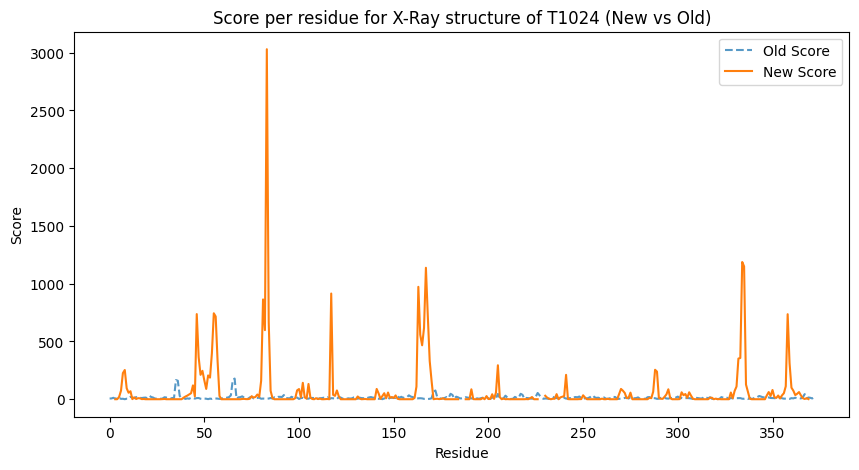

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(len(da.xray_phi_psi)), da.xray_phi_psi.da, label='Old Score', linestyle='--', alpha=0.75)
ax.plot(np.arange(len(da.xray_phi_psi)), da.xray_phi_psi.new_score, label='New Score')
ax.legend()
ax.set_title(f'Score per residue for X-Ray structure of {da.casp_protein_id} (New vs Old)')
ax.set_xlabel('Residue')
ax.set_ylabel('Score')
plt.show()

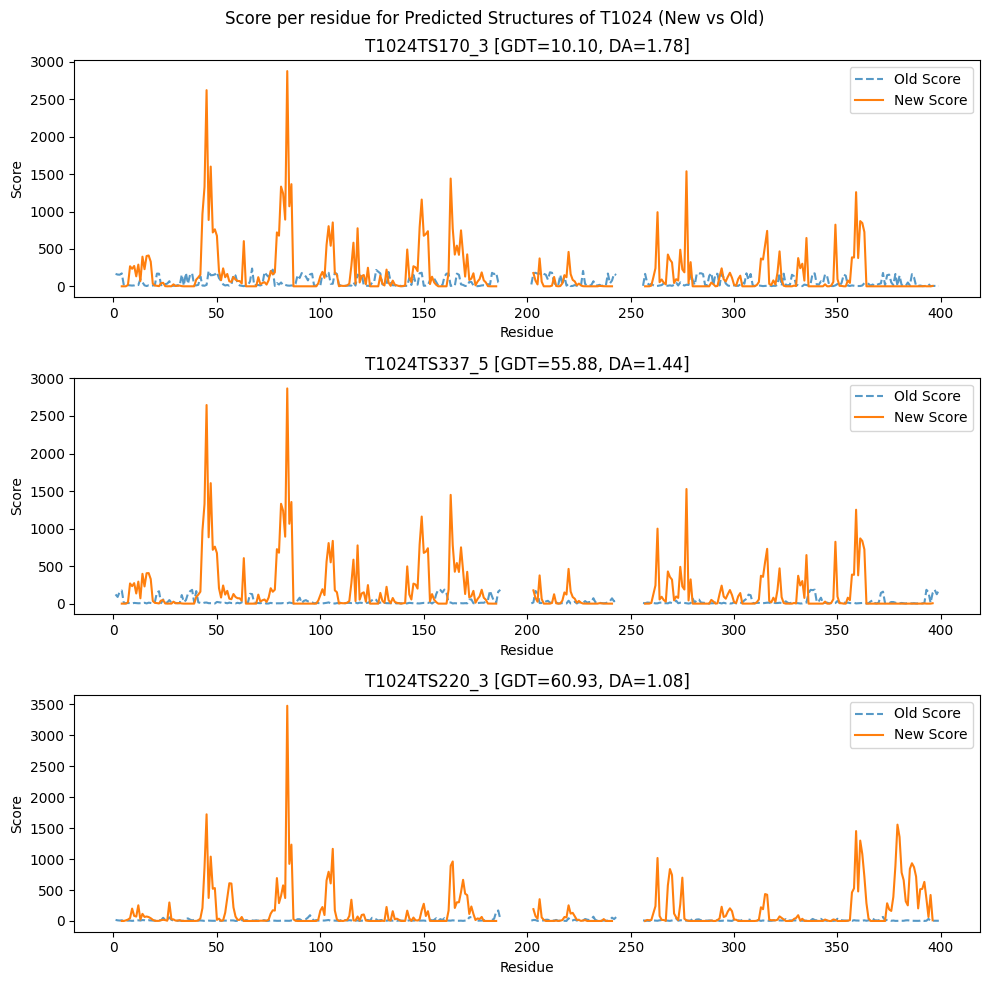

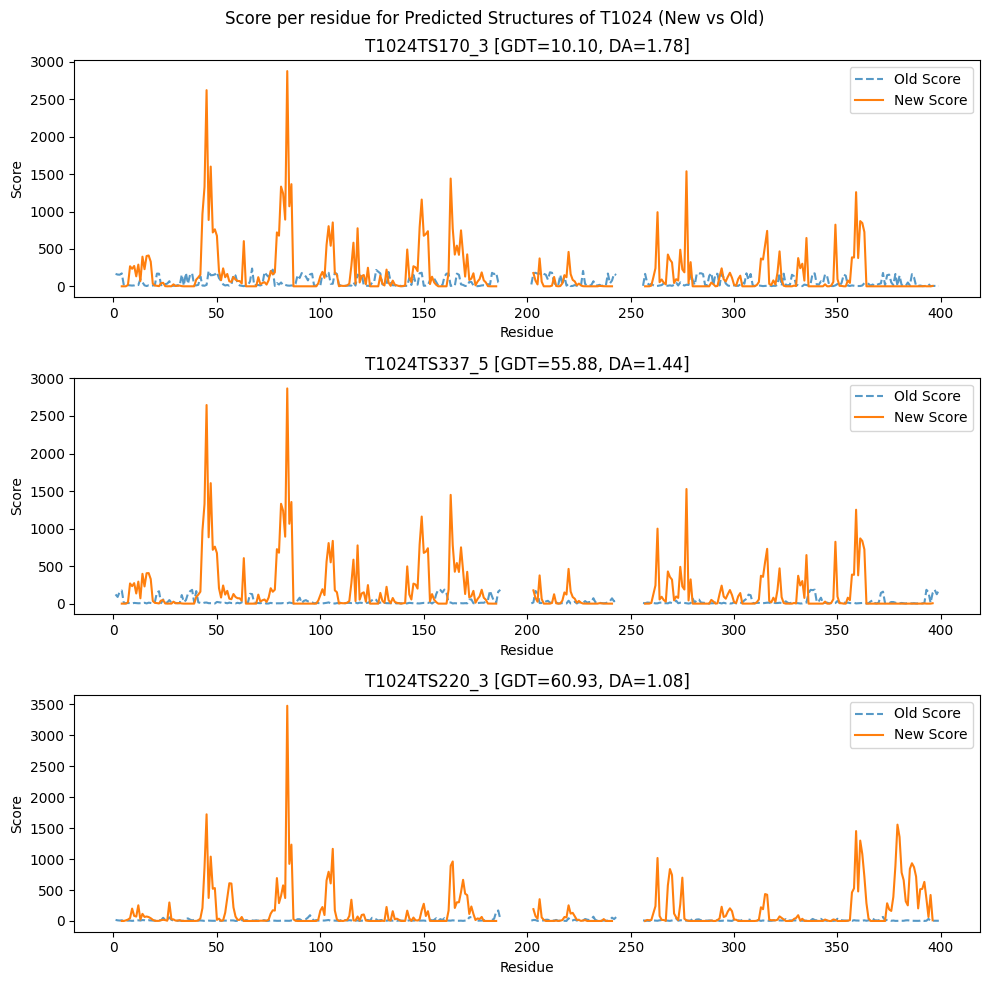

In [145]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
proteins = ['T1024TS170_3', 'T1024TS337_5', 'T1024TS220_3']
for protein,ax in zip(proteins,axes):
    preds = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == protein]
    pred_gdt = da.grouped_preds.loc[da.grouped_preds.protein_id == protein, 'GDT_TS'].iloc[0]
    pred_da = da.grouped_preds.loc[da.grouped_preds.protein_id == protein, 'log_da'].iloc[0]
    ax.plot(np.arange(len(preds)), preds.da, label='Old Score', linestyle='--', alpha=0.75)
    ax.plot(np.arange(len(preds)), preds.new_score, label='New Score')
    ax.legend()
    ax.set_title(f'{protein} [GDT={pred_gdt:.2f}, DA={pred_da:.2f}]')
    ax.set_xlabel('Residue')
    ax.set_ylabel('Score')
fig.suptitle(f'Score per residue for Predicted Structures of {da.casp_protein_id} (New vs Old)')
plt.tight_layout()
plt.show()

<Axes: >

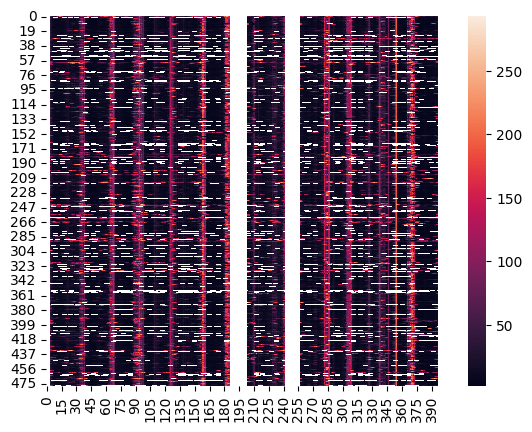

In [86]:
sns.heatmap(da.phi_psi_predictions[['protein_id', 'pos', 'new_score']].pivot(index='protein_id', columns='pos', values='new_score').values)

(478, 5)


<Axes: xlabel='new_score', ylabel='GDT_TS'>

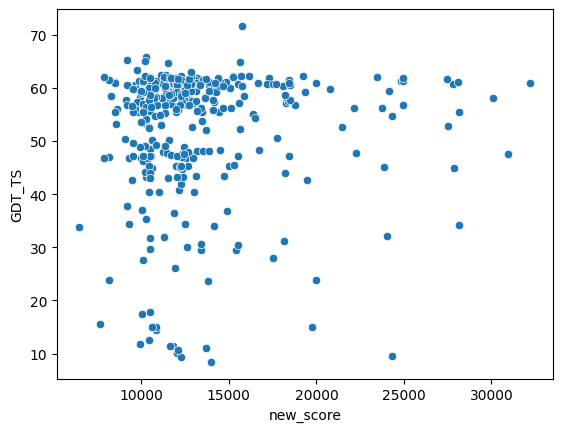

In [99]:
# worst xray ones
da.phi_psi_predictions.da_na = da.phi_psi_predictions.new_score.isna()
grouped_preds = da.phi_psi_predictions.groupby('protein_id').new_score.sum().to_frame('new_score')
grouped_preds['da_na'] = da.phi_psi_predictions[['protein_id', 'da_na']].groupby('protein_id').mean()
grouped_preds = pd.merge(
    grouped_preds.reset_index(),
    da.results[['Model', 'GDT_TS']],
    left_on='protein_id',
    right_on='Model',
    how='inner'
)
print(grouped_preds.shape)
grouped_preds = grouped_preds[grouped_preds.da_na < grouped_preds.da_na.quantile(0.8)]
sns.scatterplot(x=grouped_preds.new_score, y=grouped_preds.GDT_TS)

SAVATFV
2427


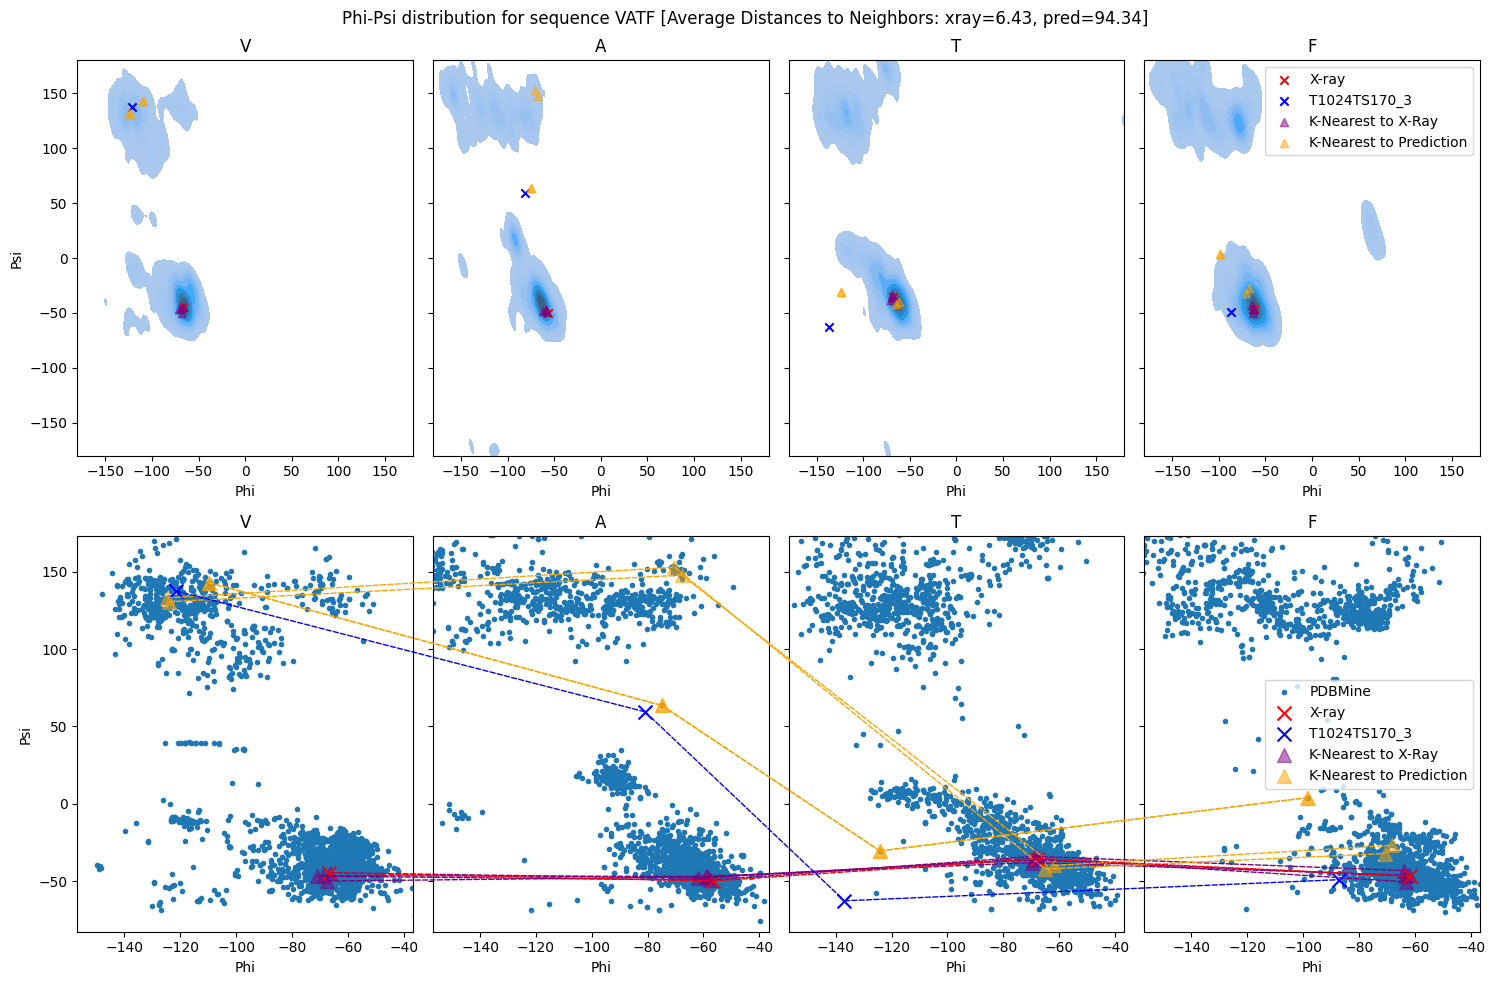

In [57]:
plot(da, da.queries[0], da.seqs[50], da.protein_ids[2], 4)